# XITASO Agile Machine Learning Workshop

This is a Jupyter notebook. It is a tool to run code and combine it with documentation.

- There are code cells and markdown cells. 
- Press the **Run** button or **Shift** + **Enter** to run a code cell or to compile a markdown cell.
- Double click into a cell to edit it.

- If the circle in the upper right corner is filled, the kernel is busy and you have to wait a bit before starting the next cell.

In this workshop we will create a machine learning model, that can classify hand-drawn images of animals.
We will work iteratively and try to improve the performance with each iteration.

One iteration consists of the steps:
1. [Data Aggregation](#1.-Data-Aggregation)
2. [Data Analysis](#2.-Data-Analysis)
3. [Data Preprocessing](#3.-Data-Preprocessing)
4. [Training](#4.-Training)
5. [Evaluation](#5.-Evaluation)

Keep track of your parameters and results, since this will give you most insights about strategies and principles when working on machine learning problems. At the end of the notebook there is a table in which you can insert your parameters. There is no fixed guideline in this workshop. Feel free to choose any improvements that seem most reasonable.

# 1. Data Aggregation

The first task is to create a dataset for training and testing the model. The more (relevant and qualitatively good) 
data you acquire, the more robust the resulting model can be.

Use our dataset generation tool to draw animals. Please draw one entire animal per image. 
Do not draw parts only (e.g. the head) and do not draw multiple animals in one image. 
We will do an image classification task where each image has the same size and the drawing stroke size is also the same.

Things you might consider:
- <font color='orange'>Amount of images per class</font>
- <font color='orange'>Level of detail</font>
- <font color='orange'>Distinctive features of each animal</font>
- <font color='orange'>Position of the animals in the image</font>
- <font color='orange'>Pose and size of the animals</font>
- <font color='orange'>Structures and contours</font>
- <font color='orange'>Diversity of the appearance</font>
- <font color='orange'>The time you spend for drawing</font>

# 2. Data Analysis
In this section we will inspect the data. Load and display some images to get a feeling for the complexity of the task.

In [7]:
# imports and general information
import os 
import cv2
import numpy as np
import random
import ipyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.applications import VGG16
import visualkeras
import matplotlib.pyplot as plt
%matplotlib inline

tf.keras.utils.set_random_seed(1)

dataset_dir = "dataset_combined"
image_names = [x for x in os.listdir(dataset_dir) if "png" in x]
classes = ["cat", "dog", "bird", "turtle", "elephant"]

### Set of Parameters
In the next cell you can experiment with the parameters. Each parameter will affect the accuracy. Don't change too many at once to understand the result.

In [8]:
FINAL_IMAGE_SIZE = 80 # image size in pixels (square images) - the size of the original images is 600x600 px

FILTER_CROP = False # crop the objects so that the entire images is filled
FILTER_OBJECT_MIN_SIZE = 200 # remove all images where the object size is smaller than FILTER_OBJECT_MIN_SIZE
FILTER_CROP_BORDER = 5 # if FILTER_CROP = True add additional white border around the cropped image

DATA_AUGMENTATION = False # if True generate additional training data by slighty transforming the training images

MODEL = "large" # choose model size: "small", "medium", "large"

TRAINING_BATCH_SIZE = 1  # number of images per batch. In each epoch the training data is split into batches.
                         # After each batch the neural network's weights are adjusted
TRAINING_NUM_EPOCHS = 20 # number of epochs for the training. In each epoch the neural network is shown all training data once
TRAINING_LEARNING_RATE = 0.0001 # how quickly the weights of the neural network are adjusted during training

In [9]:
# converts an image name to its class index
def image_name_to_class_index(image_name):
    class_name = image_name.split("_")[0]
    return classes.index(class_name)

print(classes, "\n")

for image_name in random.sample(image_names, 5):
    print("class index:", image_name_to_class_index(image_name), "\t\timage name:", image_name)

['cat', 'dog', 'bird', 'turtle', 'elephant'] 

class index: 1 		image name: dog_team1_e750ae81-d2e3-4c57-a0aa-3afa13b4327d.png
class index: 3 		image name: turtle_team1_5170cc74-412d-483a-9bec-e82c296eb1d2.png
class index: 1 		image name: dog_team2_b9e816b5-bf84-4c46-b824-f83a2d34670b.png
class index: 1 		image name: dog_team3_10dca5c7-8f76-4bcd-949e-e606065506e2.png
class index: 4 		image name: elephant_team3_44239a7f-2a40-4331-b046-e1ed761259e0.png


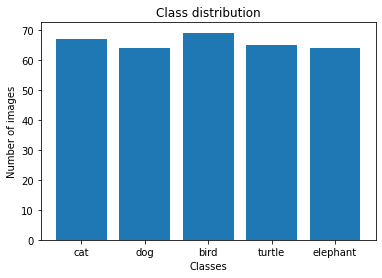


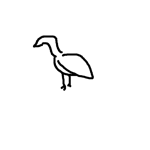
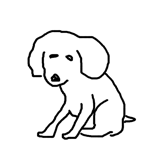
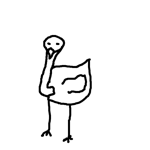
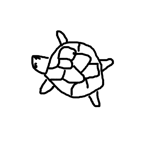
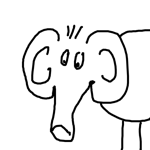
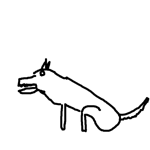
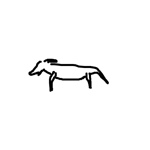
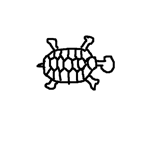
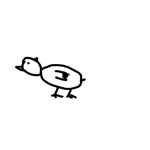
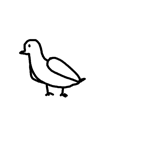
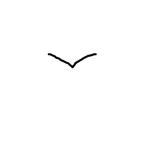
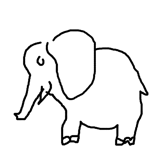
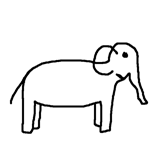
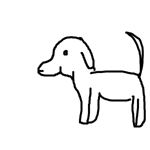
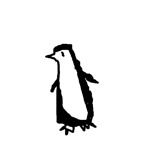
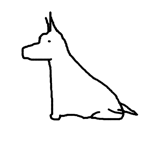


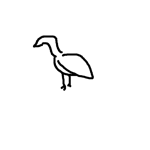
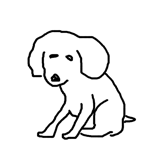
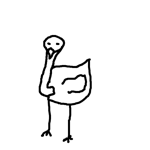
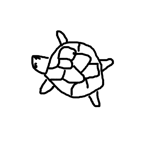
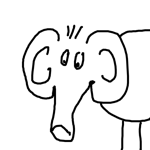
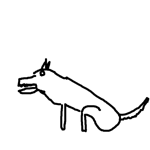
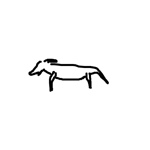
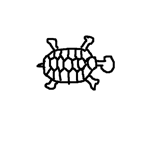
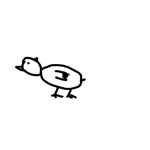
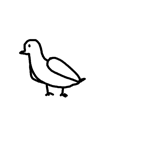
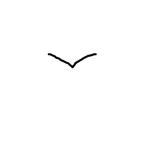
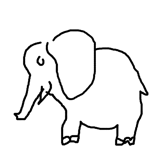
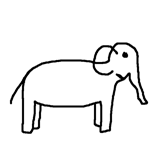
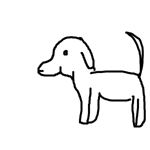
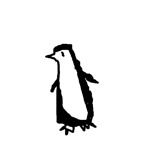
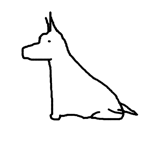

In [11]:
# loads an image from the specified path and returns the image as a numpy array
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if len(img.shape) == 3: # rgb
        if img.shape[2] == 4: # alpha
            if np.min(img[:,:,3]) == 0:
                img = cv2.cvtColor(255 - img[:,:,3], cv2.COLOR_GRAY2BGR)
            else:
                img = img[:,:,:-1]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# displays an array of images
def display_images(images, names, img_width=150):
    if len(images) > 0:
        ipyplot.plot_images(images, names, img_width=img_width)
    
# visualizes the amount of images per class
def visualize_class_distribution():
    image_labels = [classes[image_name_to_class_index(x)] for x in image_names]
    num_images_per_class = [image_labels.count(x) for x in classes]
    class_indices = list(range(len(classes)))
    
    plt.bar(class_indices, num_images_per_class)
    plt.xticks(class_indices, classes)
    plt.xlabel("Classes")
    plt.ylabel("Number of images")
    plt.title("Class distribution")
    plt.show()
    
visualize_class_distribution()

sample_names = random.sample(image_names, 16)

display_images(
    images=[load_image(dataset_dir + os.sep + image_name) for image_name in sample_names], 
    names=[classes[image_name_to_class_index(image_name)] for image_name in sample_names],
    img_width=150
)

# 3. Data Preprocessing

In this section we will prepare the data for training and testing. Therefore we split the data into the following categories:
- _Training data_ is used to train the model
- _Testing data_ is used for evaluating the model on unseen data

We load and split the data into train and test sets. Also we generate appropriate labels for training. 
A label should be a one-hot encoded vector, e.g. the label for the class with index 0 would look like this: [1, 0, 0, 0, 0].

In [12]:
# reduces the image size and optionally crops the image and filters out too small objects
def filter_image(input_img):
    if not FILTER_CROP:
        img = cv2.resize(input_img, (FINAL_IMAGE_SIZE, FINAL_IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        return img
        
    height, width = input_img.shape[:2]
    min_x, min_y = width, height
    max_x, max_y = 0, 0
    for y in range(height):
        for x in range(width):
            if input_img.item(y, x, 0) < 128:
                min_x = min(min_x, x)
                min_y = min(min_y, y)
                max_x = max(max_x, x)
                max_y = max(max_y, y)
    img = input_img[min_y : max_y + 1, min_x : max_x + 1]
    
    white = [255, 255, 255]
    height, width = img.shape[:2]
    diff = abs(int((width-height)/2))
    
    # filter out too small images
    if max(width, height) < FILTER_OBJECT_MIN_SIZE:
        return None
    
    if width == height:
        pass
    elif width > height:
        img = cv2.copyMakeBorder(img, diff, diff, 0, 0, cv2.BORDER_CONSTANT, value=white) 
    else:
        img = cv2.copyMakeBorder(img, 0, 0, diff, diff, cv2.BORDER_CONSTANT, value=white)
    
    img = cv2.resize(img, (FINAL_IMAGE_SIZE - 2*FILTER_CROP_BORDER, FINAL_IMAGE_SIZE - 2*FILTER_CROP_BORDER), 
                     interpolation=cv2.INTER_LINEAR)
    img = cv2.copyMakeBorder(img, FILTER_CROP_BORDER, FILTER_CROP_BORDER, 
                             FILTER_CROP_BORDER, FILTER_CROP_BORDER, cv2.BORDER_CONSTANT, value=white)
    
    return img

/Users/ramirolopezcento/PycharmProjects/pythonProject1/venv/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



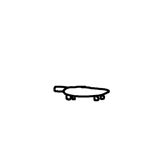
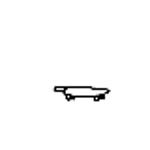
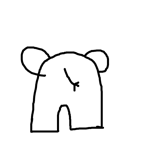
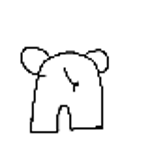
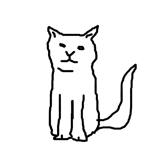
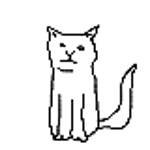
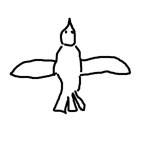
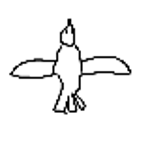
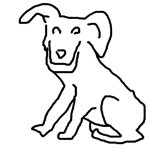
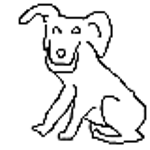


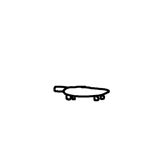
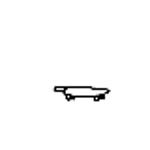
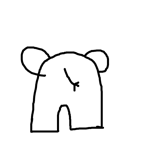
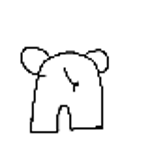
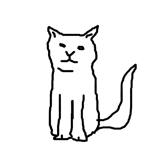
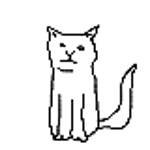
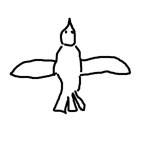
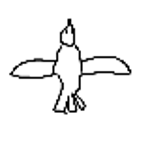
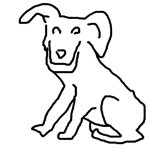
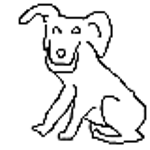

In [13]:
# displays 5 images together with the respective filtered image
def show_filtered_images():
    sample_images, sample_names = [], []
    for sample_name in random.sample(image_names, 5):
        img = load_image(dataset_dir + os.sep + sample_name)
        filtered_img = filter_image(img)
        if filtered_img is None:
            continue
        name = classes[image_name_to_class_index(sample_name)]

        sample_images.append(img)
        sample_images.append(filtered_img)
        sample_names.append(name)
        sample_names.append(name + " - filtered")

    display_images(
        images=sample_images, 
        names=sample_names,
        img_width=150
    )
    
show_filtered_images()

In [14]:
# performs an one-hot encoding of the image name
def construct_label_encoding(image_name):
    class_index = image_name_to_class_index(image_name)
    label = np.zeros(len(classes), dtype=int)
    label[class_index] = 1
    return label

print(classes, "\n")
for sample_name in random.sample(image_names, 20):
    print("encoding:", construct_label_encoding(sample_name),
          "\timage name:", sample_name)

['cat', 'dog', 'bird', 'turtle', 'elephant'] 

encoding: [0 0 0 0 1] 	image name: elephant_team2_6ae6e86f-134e-4937-85c9-b56592029201.png
encoding: [0 0 0 1 0] 	image name: turtle_team2_64a8ffd9-959a-46b9-9af9-a6c7c772688c.png
encoding: [1 0 0 0 0] 	image name: cat_team4_0cf37cf3-a737-4d95-9450-c8c9af0f6e1e.png
encoding: [1 0 0 0 0] 	image name: cat_team4_7c7f81af-3aec-4bdc-adcb-ee6b73608c11.png
encoding: [0 0 0 1 0] 	image name: turtle_team3_0ca00fd4-d0b5-492a-8e4f-d633b7bf29d7.png
encoding: [0 0 1 0 0] 	image name: bird_team1_f1bb9878-5109-47fd-bf22-1419344a801c.png
encoding: [0 0 0 1 0] 	image name: turtle_team5_1c9114b2-76b5-4112-a688-678cf7e8437c.png
encoding: [0 0 0 1 0] 	image name: turtle_team2_1d931008-1718-4623-9c7f-bb45f6101186.png
encoding: [0 0 0 0 1] 	image name: elephant_team0_b6e235f6-061a-4149-8948-298870857735.png
encoding: [0 0 0 1 0] 	image name: turtle_team6_fe8a531a-28be-483a-bdaf-5c945633f556.png
encoding: [1 0 0 0 0] 	image name: cat_team5_a6e62a6e-764a-4b0e-8fd

In [15]:
# loads the images into memory, splits the data into training and test and finally displays all removed images
def prepare_dataset():
    images, labels = [], []
    removed_images, removed_image_labels = [], []
    for image_name in image_names:
        img = load_image(image_path=dataset_dir + os.sep + image_name) 
        filtered_img = filter_image(img)
        
        if filtered_img is None:
            removed_images.append(img)
            removed_image_labels.append(classes[image_name_to_class_index(image_name)])
            continue
            
        label = construct_label_encoding(image_name)
        images.append(filtered_img)
        labels.append(label)
        
    if len(removed_images) > 0:
        display_images(removed_images, removed_image_labels, img_width=150)
    else:
        print("zero images removed")
        
    images_train, images_test, labels_train, labels_test = train_test_split(images, labels, train_size=0.8, stratify=labels)

    return np.array(images_train), np.array(labels_train), np.array(images_test), np.array(labels_test)

images_train, labels_train, images_test, labels_test = prepare_dataset()

zero images removed


total train images: 263
total train labels: 263
total test images: 66
total test labels: 66


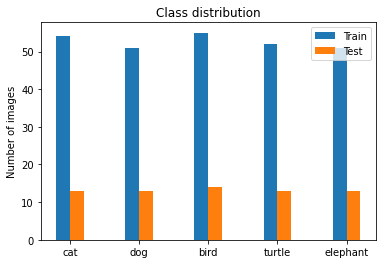

In [16]:
# displays the number of training and test images per class
def visualize_dataset_split():
    train, test = [], []
    for i in range(len(classes)):
        train.append(len([x for x in labels_train if np.argmax(x) == i]))
        test.append(len([x for x in labels_test if np.argmax(x) == i]))
        
    x = np.arange(len(classes))
    bar_width = 0.2
    
    fig, ax = plt.subplots()
    ax.bar(x - bar_width/2, train, bar_width, label="Train")
    ax.bar(x + bar_width/2, test, bar_width, label="Test")
    ax.set_ylabel("Number of images")
    ax.set_title("Class distribution")
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()
    plt.show()
    
print("total train images:", len(images_train))
print("total train labels:", len(labels_train))
print("total test images:", len(images_test))
print("total test labels:", len(labels_test))

visualize_dataset_split()

## Data Augmentation
The idea of data augmentation is to create additional data by applying transformations to the existing data.
You can configure the ImageDataGenerator to do data augmentation using affine transformations like rotation, zooming, flipping or shifting.

In [17]:
if DATA_AUGMENTATION:
    train_data_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        zoom_range=0,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=10,
        horizontal_flip=True,
        fill_mode="constant", 
        cval=255)
else:
    train_data_generator = ImageDataGenerator(rescale=1./255)

test_data_generator = ImageDataGenerator(rescale=1./255)

if DATA_AUGMENTATION:
    sample_image = random.choice(images_train)
    
    display_images(
        [sample_image], 
        ["original image"],
        img_width=150
    )
    
    index = 0
    sample_images = []
    for img in train_data_generator.flow(np.array([sample_image])):
        sample_images.append(img[0])
        index += 1
        if index > 5:
            break

    display_images(
        sample_images, 
        ["augmented" for _ in sample_images],
        img_width=150
    )

# 4. Training

The training of the neural network is split into several *epochs*. In each epoch the neural network is shown all training data once. In each epoch the training data is split into batches, e.g., 32 images per batch. After each batch the neural network's weights are adjusted, such that the neural network's output classification better matches the correct classification, i.e., the labeling we provide. How good the classification of the network matches the correct classification is determined by the *loss or error function*. The error the neural network makes during each batch is propagated backwards through the network, such that for each neuron its contribution to the error is known and its weight can be adjusted accordingly.

### Types of Layers

You can create a model by combining different layers:

**layers.Flatten()**  
This layer creates a one dimensional vector out of the previous layer. 

**layers.MaxPooling2D((2, 2))**  
This layer reduces the size of the previous layer by taking only the maximum value out of the 2x2 neuron region into account.

**layers.Dense(64, activation="relu")**  
This layer establishes full connections to all neurons of the previous layers with the current layer consisting of 64 neurons. It is the most basic form of connective layers.

**layers.Conv2D(64, (3, 3), activation="relu")**  
This layer computes a 3x3 convolution with 64 kernels. A convolution is a mathematical operation that produces one output pixel for each input pixel while taking into account the pixels surrounding the input pixel. 


### Tuning Hyperparameters

In addition to the abovementioned hyperparameters of the model, which determine its structure, the training phase itself has several hyperparameters that determine how the training proceeds:

- Number of epochs: The number of epochs until the training ends
- Batch size: Number of images per batch
- Learning rate: The learning rate defines how quickly/eagerly the weights of the neural network are adjusted during training. With a lower learning rate the parameters converge more slowly, but also more smoothly, whereas with a larger learning rate the parameters might not converge.

In [19]:
# This function creates a basic neural network
# In the input layer the image is first flattened to a one dimensional vector
# The second layer is a fully connected layer with 100 neurons
# The last layer is also fully connected and consists of 5 neurons. Each neuron represent a probability for the respective class
def create_model_small():
    model = models.Sequential()
    
    model.add(layers.Flatten(input_shape=(FINAL_IMAGE_SIZE, FINAL_IMAGE_SIZE, 3)))
    model.add(layers.Dense(100, activation="relu"))
    model.add(layers.Dense(len(classes), activation="softmax"))
    
    return model

# This function creates a larger neural network
def create_model_medium():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(FINAL_IMAGE_SIZE, FINAL_IMAGE_SIZE, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(len(classes), activation="softmax"))
    
    return model

# This function returns a pretrained neural network
# The first layers of the VGG16 model are pretrained
# if conv_base.trainable = False, the pretrained weights wont be trained again
# if conv_base.trainable = True, the pretrained weights will be trained again. 
# You can also experiment with this param, but be careful. The training can take longer.
def create_VGG16_model():
    conv_base = VGG16(weights="imagenet", 
                      include_top=False, 
                      input_shape=(FINAL_IMAGE_SIZE, FINAL_IMAGE_SIZE, 3))
    conv_base.trainable = False
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dense(len(classes), activation="softmax"))
    
    return model

if MODEL == "small":
    model = create_model_small()
elif MODEL == "medium":
    model = create_model_medium()
elif MODEL == "large":
    model = create_VGG16_model()
else:
    raise ValueError("specify model size")

model.summary()
visualkeras.layered_view(model)

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 15,240,517
Trainable params: 525,829
Non-trainable params: 14,714,688
_________________________________________________________________


Now we train the neural network. Training is also called "fitting" because we "fit" the X data (in our case the images) to the Y data (in our case the labels).

Keep track of **acc** - this is the accuracy on the training data set. 
0.2 means 20% accuracy and denotes random guessing. During a successful trainig this value should rise.

Also keep track of **val_acc** - this is the accuracy on the test data set.

If the training accuracy is high but the test accuracy is low you encounter **overfitting**. This is due to a too complex model or to simple data, so that the model learns the training data by heart and can not generalize.

If both accuracy values are low you encounter **underfitting**. This is due to a too simple model or to complex data. The model is not able to learn anything.

In [20]:
model.compile(loss = "categorical_crossentropy", 
              optimizer = optimizers.Adam(learning_rate=TRAINING_LEARNING_RATE), 
              metrics = ["acc"])

train_generator = train_data_generator.flow(images_train, labels_train, batch_size=TRAINING_BATCH_SIZE, shuffle=True)
test_generator = test_data_generator.flow(images_test, labels_test, batch_size=TRAINING_BATCH_SIZE, shuffle=True)

history = model.fit(train_generator,
                    steps_per_epoch = len(images_train) // TRAINING_BATCH_SIZE,
                    epochs = TRAINING_NUM_EPOCHS,
                    validation_data = test_generator,
                    validation_steps = len(images_test) // TRAINING_BATCH_SIZE)

Epoch 1/20
263/263 [==============================] - 10s 33ms/step - loss: 1.5430 - acc: 0.3536 - val_loss: 1.3584 - val_acc: 0.4394
Epoch 2/20
263/263 [==============================] - 9s 36ms/step - loss: 1.1795 - acc: 0.5437 - val_loss: 1.2736 - val_acc: 0.5303
Epoch 3/20
263/263 [==============================] - 9s 36ms/step - loss: 0.9823 - acc: 0.6654 - val_loss: 1.1839 - val_acc: 0.6061
Epoch 4/20
263/263 [==============================] - 9s 35ms/step - loss: 0.8436 - acc: 0.7072 - val_loss: 1.1367 - val_acc: 0.6515
Epoch 5/20
263/263 [==============================] - 9s 35ms/step - loss: 0.7487 - acc: 0.7262 - val_loss: 1.1812 - val_acc: 0.5606
Epoch 6/20
263/263 [==============================] - 9s 36ms/step - loss: 0.6605 - acc: 0.8137 - val_loss: 1.1287 - val_acc: 0.5455
Epoch 7/20
263/263 [==============================] - 10s 36ms/step - loss: 0.6090 - acc: 0.8251 - val_loss: 1.0820 - val_acc: 0.6212
Epoch 8/20
263/263 [==============================] - 9s 36ms/step 

# 5. Evaluation

The last step of each iteration is to evaluate the performance of the model. The evaluation shows whether the model generalized well from the training data set to the tes data. Then we can decide whether the performance is good enough or, if not, which steps we need to take in order to improve the performance.

A common metric for classification tasks is the accuracy. It can be computed by

\begin{align}
  \textit{Accuracy} = \frac{\textit{Number of correct classifications}}{\textit{Number of classifications made}}
\end{align}

We have 5 classes, so if the classifier would make random guesses, it would have an accuracy of 20% (e.g. it always says "turtle").

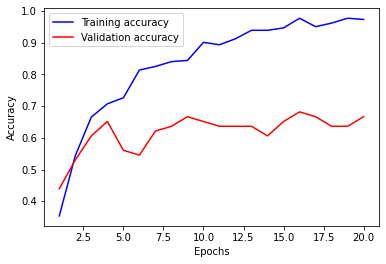

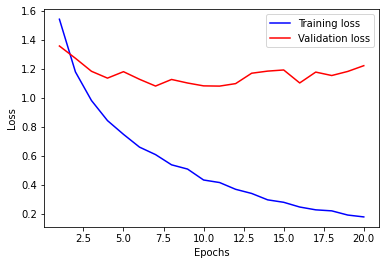

In [21]:
def plot_graphs(history):
    accuracy = history.history["acc"]
    validation_accuracy = history.history["val_acc"]
    loss = history.history["loss"]
    validation_loss = history.history["val_loss"]
    
    epochs = range(1, len(accuracy) + 1)
    
    plt.figure()
    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, validation_accuracy, "r", label="Validation accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, validation_loss, "r", label="Validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
plot_graphs(history)

total test images:  66
correct test images:  44
wrong test images:  22
total test accuracy:  0.6666666666666666

total train images:  263
correct train images:  260
wrong train images:  3
total train accuracy:  0.9885931558935361


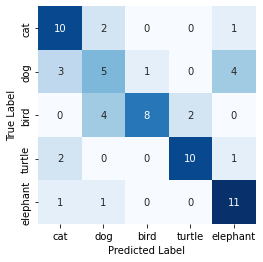

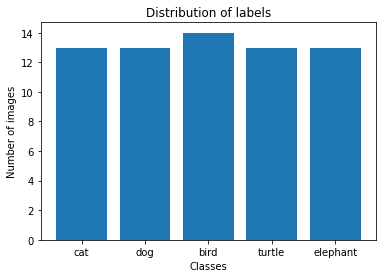

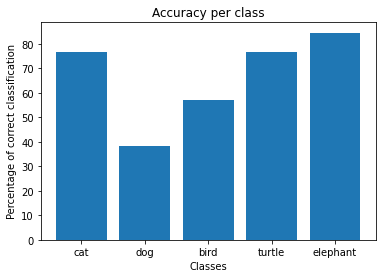

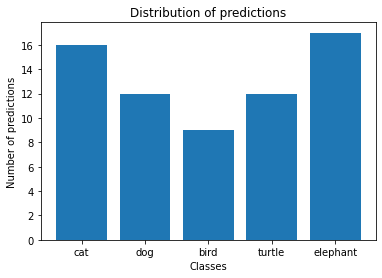

Here are all train images with a wrong classification



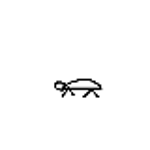
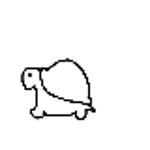
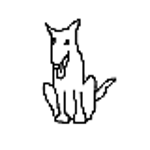


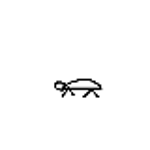
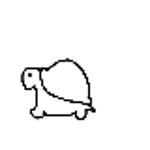
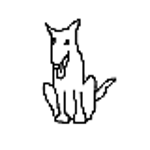

Here are all test images with a wrong classification



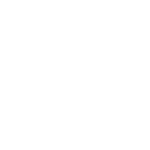
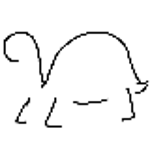
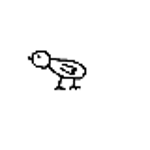
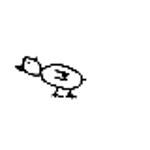
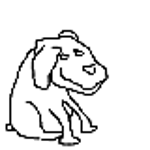
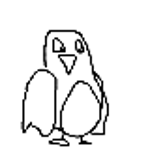
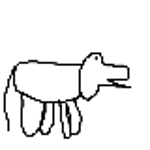
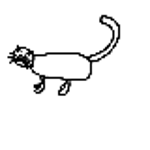
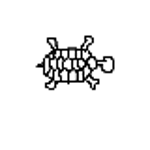
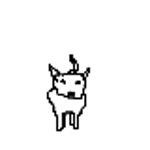
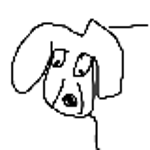
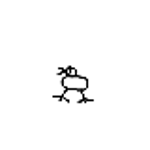
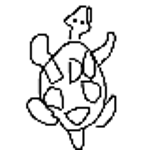
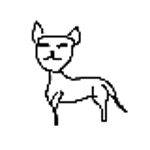
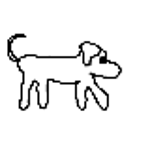
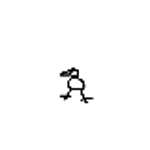
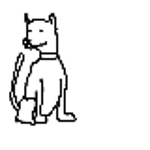
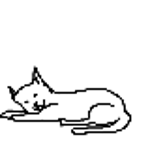
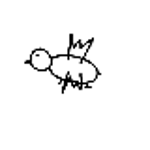
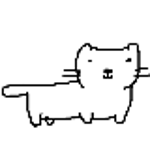
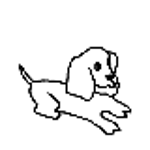
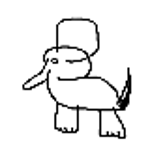


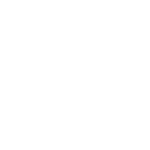
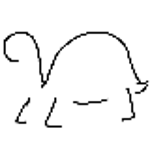
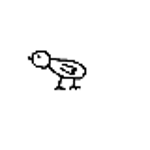
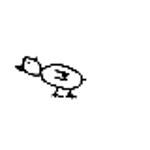
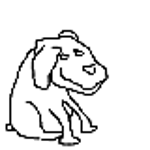
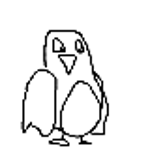
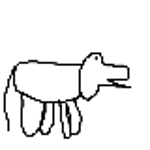
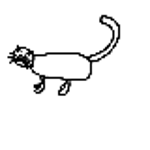
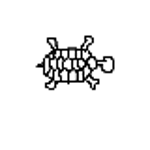
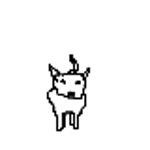
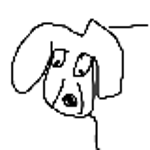
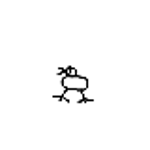
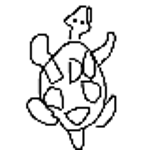
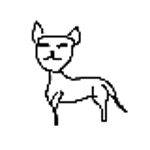
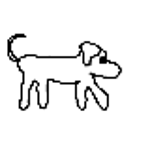
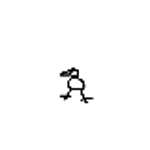
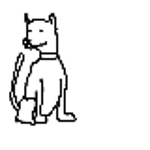
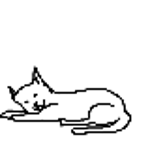
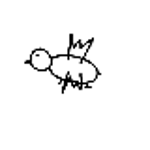
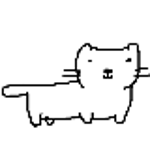
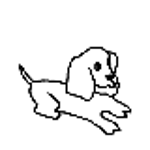
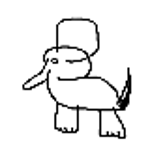

In [22]:
correct_test, correct_train = 0, 0
wrong_images_test, wrong_images_train = [], []
wrong_image_labels_test, wrong_image_labels_train = [], []
correct_per_class = np.array([0, 0, 0, 0, 0])
wrong_per_class = np.array([0, 0, 0, 0, 0])
predicted_labels = np.array([0, 0, 0, 0, 0])
correct_labels = np.array([0, 0, 0, 0, 0])
class_indices = list(range(len(classes)))
y_test, y_pred = [], []

index = 0
for image in ImageDataGenerator(rescale=1./255).flow(images_test, batch_size=1, shuffle=False):
    prediction_vector = model.predict(image)
    predicted_label = np.argmax(prediction_vector)
    prediction_score = np.max(prediction_vector)
    true_label = np.argmax(labels_test[index])
    
    if int(predicted_label) == int(true_label):
        correct_test += 1
        correct_per_class[true_label] += 1
    else:
        wrong_per_class[true_label] += 1
        wrong_images_test.append(image[0])
        wrong_image_labels_test.append("correct: " + classes[true_label] + " - classification: " + classes[predicted_label])

    predicted_labels[predicted_label] += 1
    correct_labels[true_label] += 1
    
    y_test.append(true_label)
    y_pred.append(predicted_label)
    
    index += 1
    if index >= len(images_test):
        break

index = 0
for image in ImageDataGenerator(rescale=1./255).flow(images_train, batch_size=1, shuffle=False):
    prediction_vector = model.predict(image)
    predicted_label = np.argmax(prediction_vector)
    true_label = np.argmax(labels_train[index])
    
    if int(predicted_label) == int(true_label):
        correct_train += 1
    else:
        wrong_images_train.append(image[0])
        wrong_image_labels_train.append("correct: " + classes[true_label] + " - classification: " + classes[predicted_label])

    index += 1
    if index >= len(images_train):
        break

print("total test images: ", len(images_test))
print("correct test images: ", correct_test)
print("wrong test images: ", len(images_test) - correct_test)
print("total test accuracy: ", float(correct_test) / float(len(images_test)))
print()
print("total train images: ", len(images_train))
print("correct train images: ", correct_train)
print("wrong train images: ", len(images_train) - correct_train)
print("total train accuracy: ", float(correct_train) / float(len(images_train)))

matrix_confusion = confusion_matrix(y_test, y_pred)
plt.figure(1)
ax = sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

plt.figure(2)
plt.bar(class_indices, correct_labels)
plt.xticks(class_indices, classes)
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Distribution of labels")
plt.show()

plt.figure(3)
plt.bar(class_indices, correct_per_class / (correct_per_class + wrong_per_class) * 100)
plt.xticks(class_indices, classes)
plt.xlabel("Classes")
plt.ylabel("Percentage of correct classification")
plt.title("Accuracy per class")
plt.show()

plt.figure(4)
plt.bar(class_indices, predicted_labels)
plt.xticks(class_indices, classes)
plt.xlabel("Classes")
plt.ylabel("Number of predictions")
plt.title("Distribution of predictions")
plt.show()

print("Here are all train images with a wrong classification")
display_images(
    wrong_images_train, 
    wrong_image_labels_train,
    img_width=150
)

print("Here are all test images with a wrong classification")
display_images(
    wrong_images_test, 
    wrong_image_labels_test,
    img_width=150
)

|Parameters                |Exp1  |Exp2  |Exp3  |Exp4  |Exp5  |Exp6  |Exp7  |Exp8  |Exp9  |
|--------------------------|------|------|------|------|------|------|------|------|------|
|**FINAL_IMAGE_SIZE**      |80    |      |      |      |      |      |      |      |      |
|**FILTER_CROP**           |False |      |      |      |      |      |      |      |      |
|**FILTER_OBJECT_MIN_SIZE**|200   |      |      |      |      |      |      |      |      |
|**FILTER_CROP_BORDER**    |5     |      |      |      |      |      |      |      |      |
|**DATA_AUGMENTATION**     |False |      |      |      |      |      |      |      |      |
|**MODEL**                 |small |      |      |      |      |      |      |      |      |
|**TRAINING_BATCH_SIZE**   |1     |      |      |      |      |      |      |      |      |
|**TRAINING_NUM_EPOCHS**   |20    |      |      |      |      |      |      |      |      |
|**TRAINING_LEARNING_RATE**|0.0001|      |      |      |      |      |      |      |      |
|**Total Test Accuracy**   |      |      |      |      |      |      |      |      |      |
